In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px



In [27]:
df = pd.read_csv("../Data/Merged/merged_players_clean.csv", encoding="utf-8-sig")
sns.set_theme(style="whitegrid", context="notebook", palette="deep")
df["log_value"] = np.log1p(df["market_value_eur"])

In [10]:
# df.head()          # first 5 rows
# df.tail()          # last 5 rows
# df.shape           # (rows, columns)
# df.columns         # list of column names
# df.info()          # types + missing values
# df.describe()      # numeric stats (mean, std, etc.)

In [ ]:
# Select some columns
# df[["full_name", "club_name", "market_value_eur"]].head()

# Filter
# df[df["market_value_eur"] > 50000000]

# Sort
# df.sort_values("market_value_eur", ascending=True).head(10)

# Groupby example: average value per league
# df.groupby("club_league_name")["market_value_eur"].mean().sort_values(ascending=False).head(10)


In [ ]:
# Choose a subset of interesting numeric columns
cols = [
    "market_value_eur",
    "overall_rating", "potential",
    "age", "height_cm", "weight_kg",
    "attacking_finishing", "skill_dribbling",
    "defending_standing_tackle", "power_stamina"
]
df_corr = df[cols].corr()
df_corr["market_value_eur"].sort_values(ascending=False)


In [24]:
num_cols = [
    "market_value_eur",
    "overall_rating", "potential",
    "age",
    "attacking_finishing", "skill_dribbling",
    "defending_standing_tackle", "power_stamina"
]

corr = df[num_cols].corr()
corr


,market_value_eur,overall_rating,potential,age,attacking_finishing,skill_dribbling,defending_standing_tackle,power_stamina
market_value_eur,1.000000,0.665794,0.612018,-0.055058,0.192218,0.240746,0.095994,0.130196
overall_rating,0.665794,1.000000,0.691969,0.029395,0.173284,0.219789,0.133738,0.114418
potential,0.612018,0.691969,1.000000,-0.134808,0.119359,0.218176,0.082256,0.064368
age,-0.055058,0.029395,-0.134808,1.000000,-0.113663,-0.136002,-0.030464,-0.106742
attacking_finishing,0.192218,0.173284,0.119359,-0.113663,1.000000,0.840542,0.056918,0.586823
skill_dribbling,0.240746,0.219789,0.218176,-0.136002,0.840542,1.000000,0.402108,0.734382
defending_standing_tackle,0.095994,0.133738,0.082256,-0.030464,0.056918,0.402108,1.000000,0.576279
power_stamina,0.130196,0.114418,0.064368,-0.106742,0.586823,0.734382,0.576279,1.000000


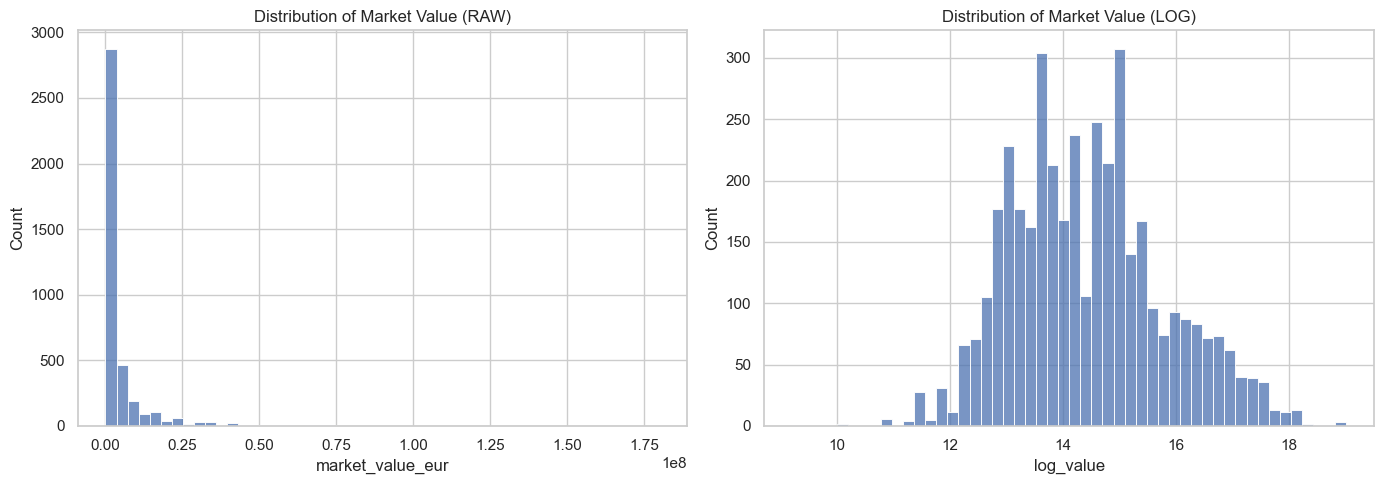

In [29]:
fig, axes = plt.subplots(1, 2, figsize=(14,5))

sns.histplot(df["market_value_eur"], bins=50, ax=axes[0])
axes[0].set_title("Distribution of Market Value (RAW)")

sns.histplot(df["log_value"], bins=50, ax=axes[1])
axes[1].set_title("Distribution of Market Value (LOG)")

plt.tight_layout()
plt.show()


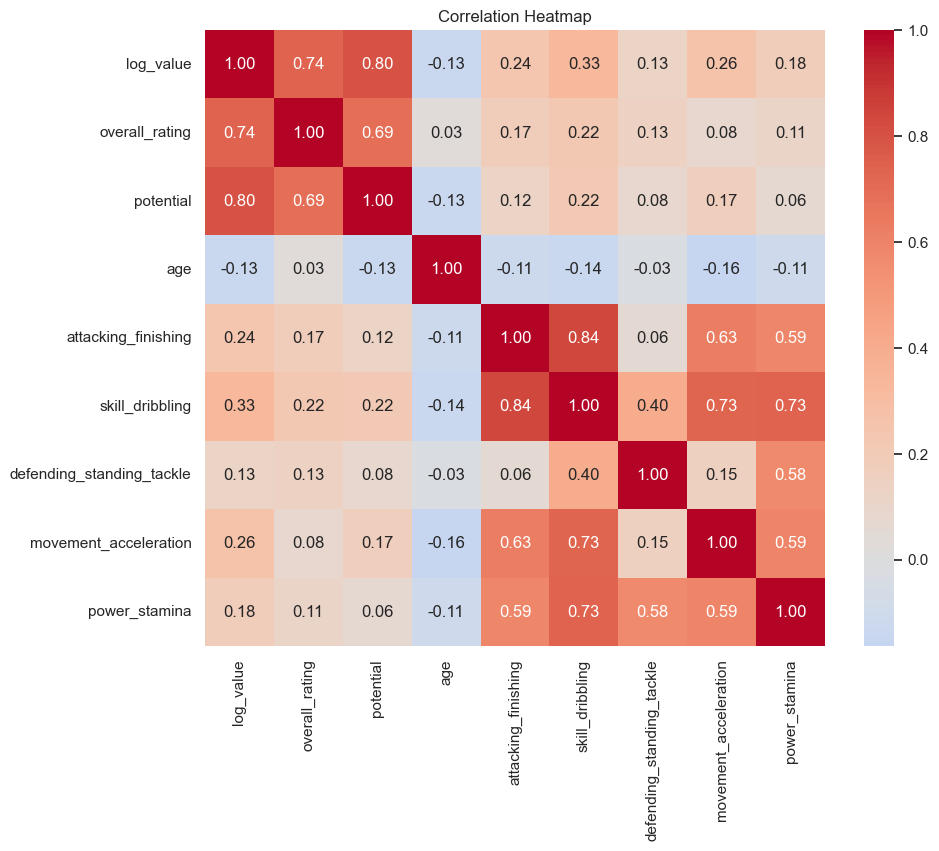

In [30]:
cols = [
    "log_value",
    "overall_rating", "potential", "age",
    "attacking_finishing", "skill_dribbling",
    "defending_standing_tackle", "movement_acceleration",
    "power_stamina"
]

corr = df[cols].corr()

plt.figure(figsize=(10,8))
sns.heatmap(
    corr, annot=True, fmt=".2f",
    cmap="coolwarm", center=0
)
plt.title("Correlation Heatmap")
plt.show()
